In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import time

#Dataset exploration

In [ ]:
dataset = CIFAR10(root='data/', train=True, download=True, transform=ToTensor())
dataset_test = CIFAR10(root='data/', train=False, download=True, transform=ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [ ]:
dataset_size = len(dataset)
dataset_size

50000

In [ ]:
dataset_test_size = len(dataset)
dataset_test_size

50000

In [ ]:
classes = dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
n_classes = len(dataset.classes)
n_classes

10

In [ ]:
img, label = dataset[0]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

Label [numeric]: 9
Label [textual]: truck


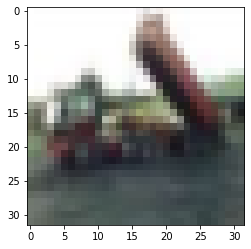

In [ ]:
img, label = dataset[2]
plt.imshow(img.permute((1, 2, 0)))
print(f'Label [numeric]: {label}')
print(f'Label [textual]: {classes[label]}')

In [ ]:
torch.manual_seed(42)
val_size = 5000
train_size = len(dataset) - val_size
train_size, val_size

(45000, 5000)

In [ ]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=5, num_workers=2, pin_memory=True)
test_dl = DataLoader(dataset_test, batch_size=5, num_workers=2, pin_memory=True)

torch.Size([100, 3, 32, 32])


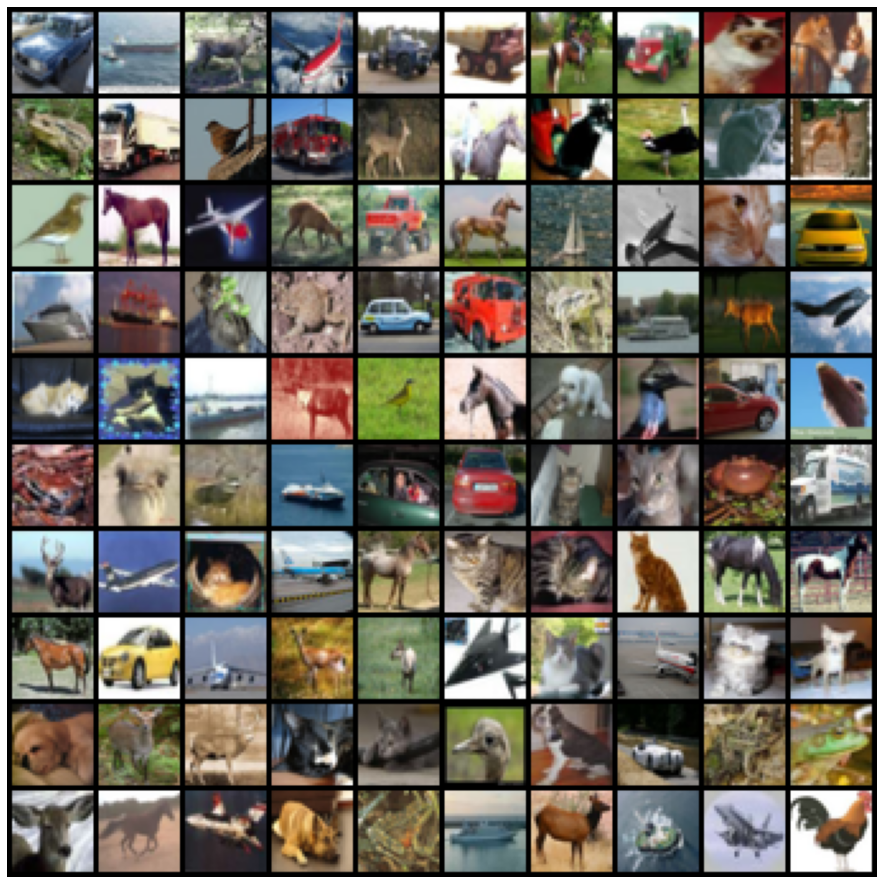

In [ ]:
for images, _ in train_dl:
  print(images.shape)
  plt.figure(figsize=(16,16))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))

  break

#Base

In [ ]:
def accuracy(out, labels):
  '''Takes tensor of probs and labels, returns the ratio of true predictions'''
  _, max_probs = torch.max(out, dim=1)
  return torch.tensor(torch.sum(max_probs == labels).item() / len(max_probs))

In [ ]:
class ImgClassificationBase(nn.Module):
  '''
  Base model for Classification
  Loss function = cross_entropy
  Need to define __init__ and forward
  '''
  def training_step(self, batch):
    '''Takes batch, returns loss (cross_entropy)'''
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    '''Takes batch, returns loss and accuracy'''
    images, labels = batch
    out = self(images)
    val_loss = F.cross_entropy(out, labels)
    val_acc = accuracy(out, labels)
    return {'val_loss': val_loss, 'val_acc': val_acc}

  def validation_epoch_end(self, result):
    '''Takes list of losses and accuracies, returns mean of both'''
    losses = [x['val_loss'] for x in result]
    epoch_loss = torch.stack(losses).mean()
    accs = [x['val_acc'] for x in result]
    epoch_acc = torch.stack(accs).mean()
    return {'epoch_loss': epoch_loss.detach().item(), 'epoch_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    '''Takes epoch number, mean loss, mean accuracy, prits it'''
    print(f'Epoch: [{epoch}], Validation loss: [{round(result["epoch_loss"], 4)}], Validation accuracy: [{round(result["epoch_acc"], 4)}]')

In [ ]:
def evaluate(model, val_loader):
  '''Takes model and validation loader, runs validation_step and validation_epoch_end'''
  res = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(res)

In [ ]:
def fit(n_epochs, model, train_loader, val_loader, lr, opt_f=torch.optim.SGD):
  '''
  Takes n_epoch, model, train_loader, val_loader, learning rate and opt_f(SGD) as default
  Runs training step, and evaluates the perfomance
  Returns list of dicts of losses and accuracies
  '''
  history = []
  opt = opt_f(model.parameters(), lr)

  for epoch in range(n_epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      opt.step()
      opt.zero_grad()

    res = evaluate(model, val_loader)
    history.append(res)
    model.epoch_end(epoch, res)

  return history

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
  '''Moves data to chosen device'''
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
  '''Wrap a dataloader to move data to device'''
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    '''Yield a batch of data after moving it to device'''
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    '''Number of batches'''
    return len(self.dl)

In [ ]:
def plot_losses(history):
  losses = [x['epoch_loss'] for x in history]
  plt.figure(figsize=(25,8))
  plt.plot(losses, label='Validation losses')
  plt.xlabel('Epoch')
  plt.ylabel('Score')
  plt.title('Loss x N of epochs')
  plt.legend();

In [ ]:
def plot_accuracies(history):
  accs = [x['epoch_acc'] for x in history]
  plt.figure(figsize=(25,8))
  plt.plot(accs, label='Validation accuracies')
  plt.xlabel('Epoch')
  plt.ylabel('Score')
  plt.title('Accuracy x N of epochs')
  plt.legend();

In [ ]:
train_loader = DeviceDataLoader(dl=train_dl, device=device)
validation_loader = DeviceDataLoader(dl=val_dl, device=device)
test_loader = DeviceDataLoader(dl=test_dl, device=device)

In [ ]:
for b in train_loader:
  x, y = b
  print(x.shape)
  print(y.shape)
  break

torch.Size([100, 3, 32, 32])
torch.Size([100])


In [ ]:
input_size = 3 * 32 * 32
n_classes = 10

#Models

##1st model

In [ ]:
class cifar10model_1(ImgClassificationBase):
  '''Model with 2 hidden layers, layer sizes: 3072-100-50-25-10'''

  def __init__(self, input_size, n_classes):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 100)  # INPUT LAYER
    self.linear2 = nn.Linear(100, 50)          # HIDDEN LAYER 1
    self.linear3 = nn.Linear(50, 25)           # HIDDER LAYER 2
    self.linear4 = nn.Linear(25, 10)           # OUTPUT LAYER

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    return out

In [ ]:
model_1 = cifar10model_1(input_size, n_classes)

In [ ]:
model_1 = to_device(model_1, device)

In [ ]:
history = [evaluate(model_1, validation_loader)]
history

[{'epoch_acc': 0.09539999812841415, 'epoch_loss': 2.3070309162139893}]

In [ ]:
history += fit(10, model_1, train_loader, validation_loader, lr=0.5)

Epoch: [0], Validation loss: [2.18], Validation accuracy: [0.1594]
Epoch: [1], Validation loss: [2.332], Validation accuracy: [0.154]
Epoch: [2], Validation loss: [2.0883], Validation accuracy: [0.2184]
Epoch: [3], Validation loss: [2.0213], Validation accuracy: [0.231]
Epoch: [4], Validation loss: [1.9586], Validation accuracy: [0.2468]
Epoch: [5], Validation loss: [1.9006], Validation accuracy: [0.2896]
Epoch: [6], Validation loss: [1.9903], Validation accuracy: [0.285]
Epoch: [7], Validation loss: [1.8659], Validation accuracy: [0.3082]
Epoch: [8], Validation loss: [1.8145], Validation accuracy: [0.3482]
Epoch: [9], Validation loss: [1.7788], Validation accuracy: [0.3666]


In [ ]:
history += fit(15, model_1, train_loader, validation_loader, lr=0.4)

Epoch: [0], Validation loss: [2.0961], Validation accuracy: [0.1964]
Epoch: [1], Validation loss: [2.1326], Validation accuracy: [0.1804]
Epoch: [2], Validation loss: [2.0707], Validation accuracy: [0.2048]
Epoch: [3], Validation loss: [2.138], Validation accuracy: [0.1762]
Epoch: [4], Validation loss: [2.0388], Validation accuracy: [0.217]
Epoch: [5], Validation loss: [2.0577], Validation accuracy: [0.2046]
Epoch: [6], Validation loss: [1.9901], Validation accuracy: [0.2336]
Epoch: [7], Validation loss: [1.9771], Validation accuracy: [0.259]
Epoch: [8], Validation loss: [1.9557], Validation accuracy: [0.2646]
Epoch: [9], Validation loss: [1.9825], Validation accuracy: [0.2104]
Epoch: [10], Validation loss: [1.9998], Validation accuracy: [0.263]
Epoch: [11], Validation loss: [1.9727], Validation accuracy: [0.2492]
Epoch: [12], Validation loss: [1.9278], Validation accuracy: [0.274]
Epoch: [13], Validation loss: [1.9031], Validation accuracy: [0.2878]
Epoch: [14], Validation loss: [1.94

In [ ]:
history += fit(10, model_1, train_loader, validation_loader, lr=0.05)

Epoch: [0], Validation loss: [1.8132], Validation accuracy: [0.3236]
Epoch: [1], Validation loss: [1.7944], Validation accuracy: [0.335]
Epoch: [2], Validation loss: [1.7761], Validation accuracy: [0.3482]
Epoch: [3], Validation loss: [1.7772], Validation accuracy: [0.3434]
Epoch: [4], Validation loss: [1.7688], Validation accuracy: [0.3478]
Epoch: [5], Validation loss: [1.7695], Validation accuracy: [0.349]
Epoch: [6], Validation loss: [1.7625], Validation accuracy: [0.3544]
Epoch: [7], Validation loss: [1.7571], Validation accuracy: [0.3544]
Epoch: [8], Validation loss: [1.7522], Validation accuracy: [0.3552]
Epoch: [9], Validation loss: [1.7567], Validation accuracy: [0.3514]


In [ ]:
history += fit(10, model_1, train_loader, validation_loader, lr=0.005)

Epoch: [0], Validation loss: [1.7448], Validation accuracy: [0.3574]
Epoch: [1], Validation loss: [1.7429], Validation accuracy: [0.3644]
Epoch: [2], Validation loss: [1.7425], Validation accuracy: [0.3626]
Epoch: [3], Validation loss: [1.7433], Validation accuracy: [0.3618]
Epoch: [4], Validation loss: [1.7417], Validation accuracy: [0.3588]
Epoch: [5], Validation loss: [1.7413], Validation accuracy: [0.3614]
Epoch: [6], Validation loss: [1.7405], Validation accuracy: [0.361]
Epoch: [7], Validation loss: [1.7403], Validation accuracy: [0.3592]
Epoch: [8], Validation loss: [1.7391], Validation accuracy: [0.3616]
Epoch: [9], Validation loss: [1.7391], Validation accuracy: [0.362]


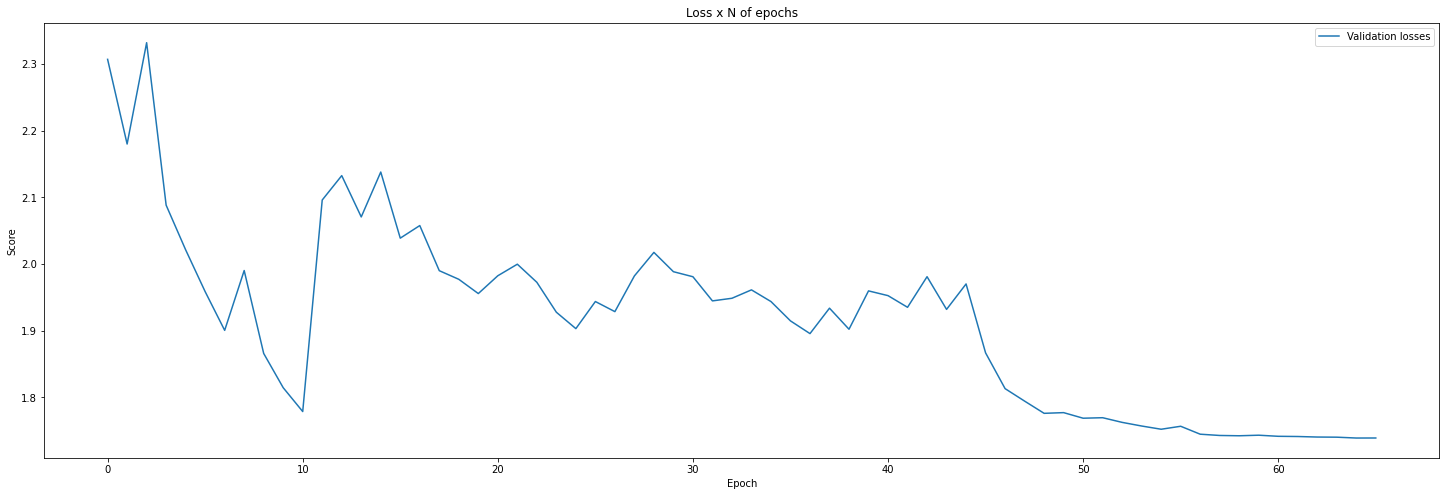

In [ ]:
plot_losses(history)

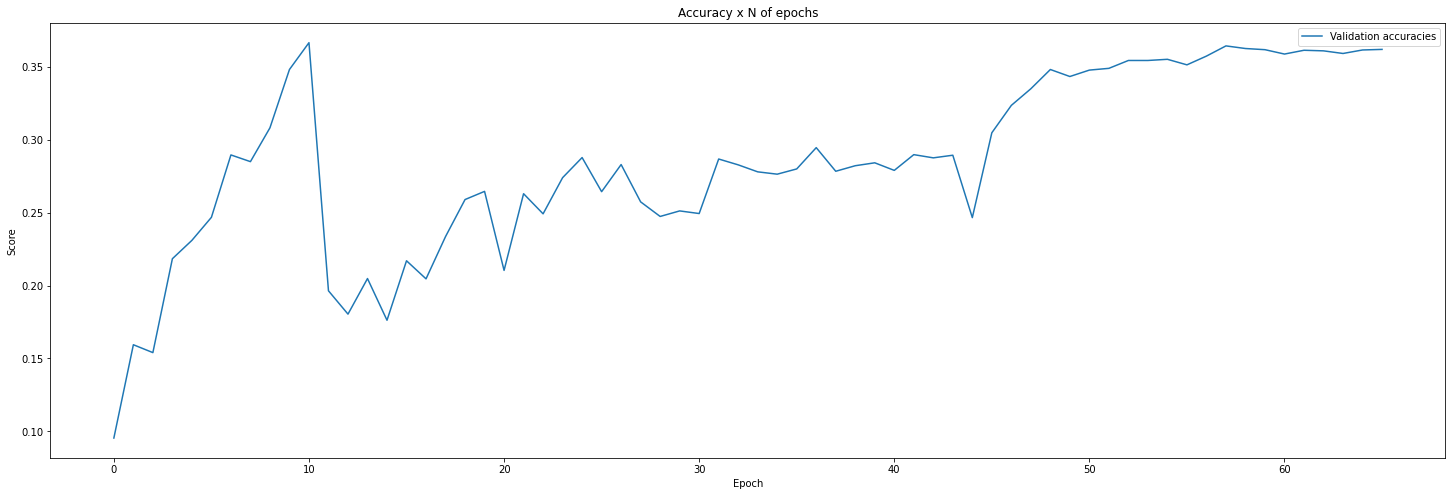

In [ ]:
plot_accuracies(history)

In [ ]:
evaluate(model_1, test_loader)

{'epoch_acc': 0.3636999726295471, 'epoch_loss': 1.725175142288208}

##Model 2

In [ ]:
input_size, n_classes

(3072, 10)

In [ ]:
x = 3072
__ = []
while x > 10:
  __.append(x)
  x = x // 2
__

[3072, 1536, 768, 384, 192, 96, 48, 24, 12]

In [ ]:
class cifar10model_2(ImgClassificationBase):
  '''
  6 hidden layers: input(3072)--1500--750--375--160--80--40--20--output(10)
  Activation: ReLU
  '''
  def __init__(self, input_size, n_classes):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 1500)
    self.linear2 = nn.Linear(1500, 750)
    self.linear3 = nn.Linear(750, 375)
    self.linear4 = nn.Linear(375, 160)
    self.linear5 = nn.Linear(160, 80)
    self.linear6 = nn.Linear(80, 40)
    self.linear7 = nn.Linear(40, 20)
    self.linear8 = nn.Linear(20, n_classes)
  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    out = F.relu(out)
    out = self.linear5(out)
    out = F.relu(out)
    out = self.linear6(out)
    out = F.relu(out)
    out = self.linear7(out)
    out = F.relu(out)
    out = self.linear8(out)
    return out

In [ ]:
model2 = cifar10model_2(input_size, n_classes)

In [ ]:
model2 = to_device(model2, device)

In [ ]:
history_2 = [evaluate(model2, validation_loader)]
history_2

[{'epoch_acc': 0.09759999066591263, 'epoch_loss': 2.316164493560791}]

In [ ]:
history_2 += fit(10, model2, train_loader, validation_loader, 0.45)

Epoch: [0], Validation loss: [2.3063], Validation accuracy: [0.0942]
Epoch: [1], Validation loss: [2.3037], Validation accuracy: [0.1008]
Epoch: [2], Validation loss: [2.3038], Validation accuracy: [0.1]
Epoch: [3], Validation loss: [2.3039], Validation accuracy: [0.0942]
Epoch: [4], Validation loss: [2.1654], Validation accuracy: [0.1684]
Epoch: [5], Validation loss: [2.1061], Validation accuracy: [0.1846]
Epoch: [6], Validation loss: [2.0632], Validation accuracy: [0.1998]
Epoch: [7], Validation loss: [2.0455], Validation accuracy: [0.191]
Epoch: [8], Validation loss: [1.9754], Validation accuracy: [0.2032]
Epoch: [9], Validation loss: [1.918], Validation accuracy: [0.258]


In [ ]:
history_2 += fit(25, model2, train_loader, validation_loader, 0.3)

Epoch: [0], Validation loss: [1.8591], Validation accuracy: [0.2836]
Epoch: [1], Validation loss: [1.8379], Validation accuracy: [0.3148]
Epoch: [2], Validation loss: [1.7344], Validation accuracy: [0.357]
Epoch: [3], Validation loss: [1.7227], Validation accuracy: [0.3594]
Epoch: [4], Validation loss: [1.6531], Validation accuracy: [0.4]
Epoch: [5], Validation loss: [1.6968], Validation accuracy: [0.3768]
Epoch: [6], Validation loss: [1.6244], Validation accuracy: [0.4196]
Epoch: [7], Validation loss: [1.576], Validation accuracy: [0.4406]
Epoch: [8], Validation loss: [1.5827], Validation accuracy: [0.4334]
Epoch: [9], Validation loss: [1.5346], Validation accuracy: [0.45]
Epoch: [10], Validation loss: [1.5894], Validation accuracy: [0.4222]
Epoch: [11], Validation loss: [1.559], Validation accuracy: [0.4446]
Epoch: [12], Validation loss: [1.8088], Validation accuracy: [0.4018]
Epoch: [13], Validation loss: [1.579], Validation accuracy: [0.4556]
Epoch: [14], Validation loss: [1.5371],

In [ ]:
history_2 += fit(15, model2, train_loader, validation_loader, 0.2)

Epoch: [0], Validation loss: [1.4958], Validation accuracy: [0.5026]
Epoch: [1], Validation loss: [1.5313], Validation accuracy: [0.5]
Epoch: [2], Validation loss: [1.5215], Validation accuracy: [0.5068]
Epoch: [3], Validation loss: [1.5609], Validation accuracy: [0.5064]
Epoch: [4], Validation loss: [1.6089], Validation accuracy: [0.5136]
Epoch: [5], Validation loss: [1.5393], Validation accuracy: [0.5188]
Epoch: [6], Validation loss: [1.5584], Validation accuracy: [0.5168]
Epoch: [7], Validation loss: [1.6251], Validation accuracy: [0.5058]
Epoch: [8], Validation loss: [1.6375], Validation accuracy: [0.5102]
Epoch: [9], Validation loss: [1.6825], Validation accuracy: [0.511]
Epoch: [10], Validation loss: [1.6552], Validation accuracy: [0.5094]
Epoch: [11], Validation loss: [1.7135], Validation accuracy: [0.5052]
Epoch: [12], Validation loss: [1.8175], Validation accuracy: [0.4894]
Epoch: [13], Validation loss: [1.8232], Validation accuracy: [0.5084]
Epoch: [14], Validation loss: [1.7

In [ ]:
history_2 += fit(15, model2, train_loader, validation_loader, 0.1)

Epoch: [0], Validation loss: [2.0192], Validation accuracy: [0.5156]
Epoch: [1], Validation loss: [2.1944], Validation accuracy: [0.51]
Epoch: [2], Validation loss: [2.3081], Validation accuracy: [0.5078]
Epoch: [3], Validation loss: [2.3228], Validation accuracy: [0.5156]
Epoch: [4], Validation loss: [2.3789], Validation accuracy: [0.5122]
Epoch: [5], Validation loss: [2.3553], Validation accuracy: [0.5116]
Epoch: [6], Validation loss: [2.4643], Validation accuracy: [0.5122]
Epoch: [7], Validation loss: [2.4689], Validation accuracy: [0.5002]
Epoch: [8], Validation loss: [2.5091], Validation accuracy: [0.516]
Epoch: [9], Validation loss: [2.6803], Validation accuracy: [0.5096]
Epoch: [10], Validation loss: [2.613], Validation accuracy: [0.508]
Epoch: [11], Validation loss: [2.7756], Validation accuracy: [0.4986]
Epoch: [12], Validation loss: [2.7869], Validation accuracy: [0.5082]
Epoch: [13], Validation loss: [2.7423], Validation accuracy: [0.508]
Epoch: [14], Validation loss: [2.665

In [ ]:
history_2 += fit(15, model2, train_loader, validation_loader, 0.05)

Epoch: [0], Validation loss: [3.1858], Validation accuracy: [0.523]
Epoch: [1], Validation loss: [3.4775], Validation accuracy: [0.521]
Epoch: [2], Validation loss: [3.8762], Validation accuracy: [0.5126]
Epoch: [3], Validation loss: [4.0476], Validation accuracy: [0.5154]
Epoch: [4], Validation loss: [4.0923], Validation accuracy: [0.518]
Epoch: [5], Validation loss: [4.3285], Validation accuracy: [0.5212]
Epoch: [6], Validation loss: [4.3173], Validation accuracy: [0.5098]
Epoch: [7], Validation loss: [4.4979], Validation accuracy: [0.5186]
Epoch: [8], Validation loss: [4.4378], Validation accuracy: [0.5116]
Epoch: [9], Validation loss: [4.5459], Validation accuracy: [0.506]
Epoch: [10], Validation loss: [4.4601], Validation accuracy: [0.5142]
Epoch: [11], Validation loss: [4.553], Validation accuracy: [0.5114]
Epoch: [12], Validation loss: [4.4361], Validation accuracy: [0.5094]
Epoch: [13], Validation loss: [4.5642], Validation accuracy: [0.4996]
Epoch: [14], Validation loss: [4.42

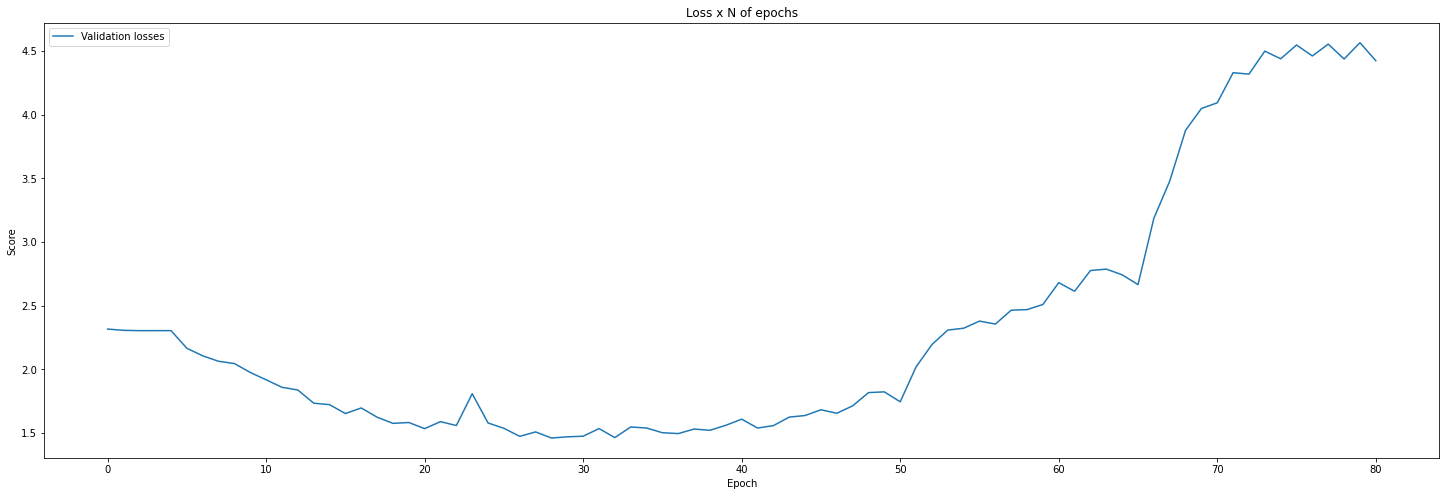

In [ ]:
plot_losses(history_2)

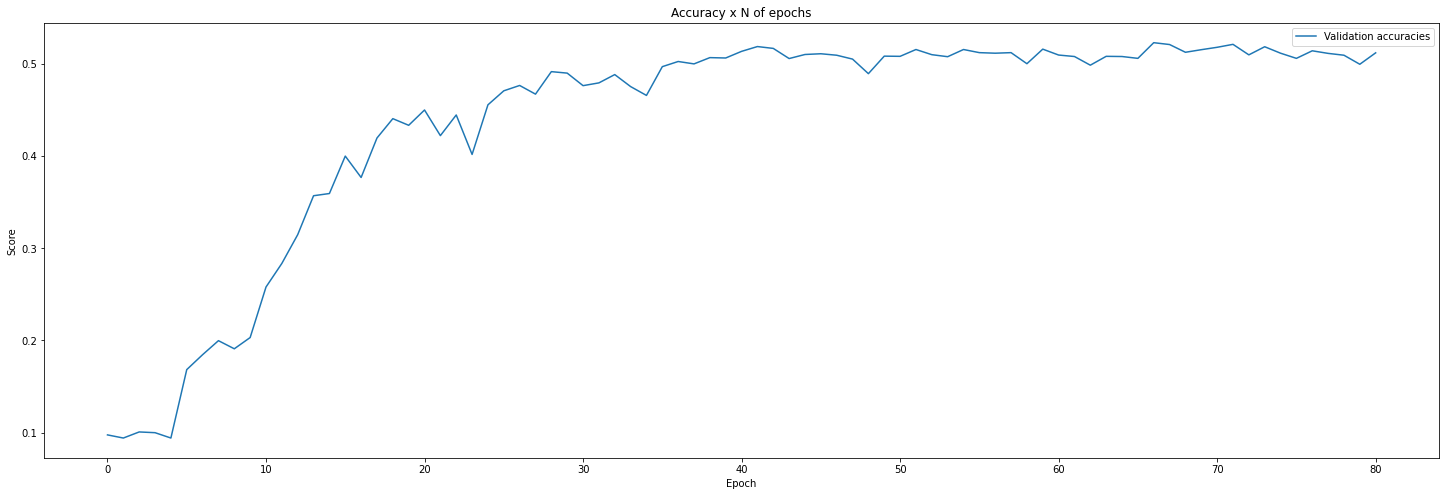

In [ ]:
plot_accuracies(history_2)

##Model 3

In [ ]:
class cifar10model_3(ImgClassificationBase):
  '''
  10 hidden layers
  input(3072)--2500--2000--1500--1000--500--250--100--75--50--25--output(10)
  Activation: ReLU
  '''
  def __init__(self, input_size, n_classes):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 2500)
    self.linear2 = nn.Linear(2500, 2000)
    self.linear3 = nn.Linear(2000, 1500)
    self.linear4 = nn.Linear(1500, 1000)
    self.linear5 = nn.Linear(1000, 500)
    self.linear6 = nn.Linear(500, 250)
    self.linear7 = nn.Linear(250, 100)
    self.linear8 = nn.Linear(100, 75)
    self.linear9 = nn.Linear(75, 50)
    self.linear10 = nn.Linear(50, 25)
    self.linear11 = nn.Linear(25, 20)
    self.linear12 = nn.Linear(20, n_classes)
  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    out = F.relu(out)
    out = self.linear5(out)
    out = F.relu(out)
    out = self.linear6(out)
    out = F.relu(out)
    out = self.linear7(out)
    out = F.relu(out)
    out = self.linear8(out)
    out = F.relu(out)
    out = self.linear9(out)
    out = F.relu(out)
    out = self.linear10(out)
    out = F.relu(out)
    out = self.linear11(out)
    out = F.relu(out)
    out = self.linear12(out)
    return out

In [ ]:
model3 = cifar10model_3(input_size, n_classes)

In [ ]:
model3 = to_device(model3, device)

In [ ]:
history_3 = [evaluate(model3, validation_loader)]
history_3

[{'epoch_acc': 0.10020000487565994, 'epoch_loss': 2.3108203411102295}]

In [ ]:
history_3 += fit(10, model3, train_loader, validation_loader, 0.5)

Epoch: [0], Validation loss: [2.3035], Validation accuracy: [0.1064]
Epoch: [1], Validation loss: [2.3043], Validation accuracy: [0.0942]
Epoch: [2], Validation loss: [2.3046], Validation accuracy: [0.0976]
Epoch: [3], Validation loss: [2.3044], Validation accuracy: [0.1014]
Epoch: [4], Validation loss: [2.3034], Validation accuracy: [0.0942]
Epoch: [5], Validation loss: [2.3039], Validation accuracy: [0.0942]
Epoch: [6], Validation loss: [2.3028], Validation accuracy: [0.1028]
Epoch: [7], Validation loss: [2.3031], Validation accuracy: [0.1028]
Epoch: [8], Validation loss: [2.3044], Validation accuracy: [0.1064]
Epoch: [9], Validation loss: [2.3036], Validation accuracy: [0.0942]


In [ ]:
history_3 += fit(10, model3, train_loader, validation_loader, 0.1)

Epoch: [0], Validation loss: [2.3032], Validation accuracy: [0.0976]
Epoch: [1], Validation loss: [2.3033], Validation accuracy: [0.0942]
Epoch: [2], Validation loss: [2.303], Validation accuracy: [0.0976]
Epoch: [3], Validation loss: [2.3026], Validation accuracy: [0.1008]
Epoch: [4], Validation loss: [2.3031], Validation accuracy: [0.1002]
Epoch: [5], Validation loss: [2.3027], Validation accuracy: [0.1]
Epoch: [6], Validation loss: [2.303], Validation accuracy: [0.0942]
Epoch: [7], Validation loss: [2.3025], Validation accuracy: [0.1]
Epoch: [8], Validation loss: [2.3027], Validation accuracy: [0.1028]
Epoch: [9], Validation loss: [2.3033], Validation accuracy: [0.0976]


In [ ]:
history_3 += fit(10, model3, train_loader, validation_loader, 0.001)

Epoch: [0], Validation loss: [2.3033], Validation accuracy: [0.0976]
Epoch: [1], Validation loss: [2.3033], Validation accuracy: [0.0976]
Epoch: [2], Validation loss: [2.3032], Validation accuracy: [0.0976]
Epoch: [3], Validation loss: [2.3032], Validation accuracy: [0.0976]
Epoch: [4], Validation loss: [2.3032], Validation accuracy: [0.0976]
Epoch: [5], Validation loss: [2.3032], Validation accuracy: [0.0976]
Epoch: [6], Validation loss: [2.3031], Validation accuracy: [0.0976]
Epoch: [7], Validation loss: [2.3031], Validation accuracy: [0.0976]
Epoch: [8], Validation loss: [2.3031], Validation accuracy: [0.0976]
Epoch: [9], Validation loss: [2.3031], Validation accuracy: [0.0976]


In [ ]:
class cifar10model_4(ImgClassificationBase):
  '''
  1 hidden layer
  input(3072)--300--30--output(10)
  Activation: ReLU
  '''
  def __init__(self, input_size, n_classes):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 300)
    self.linear2 = nn.Linear(300, 30)
    self.linear3 = nn.Linear(30, n_classes)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    return out

In [ ]:
model4 = cifar10model_4(input_size, n_classes)

In [ ]:
model4 = to_device(model4, device)

In [ ]:
history_4 = [evaluate(model4, validation_loader)]
history_4

[{'epoch_acc': 0.10020000487565994, 'epoch_loss': 2.3083598613739014}]

In [ ]:
history_4 += fit(10, model4, train_loader, validation_loader, 0.5)

Epoch: [0], Validation loss: [2.2766], Validation accuracy: [0.105]
Epoch: [1], Validation loss: [2.3042], Validation accuracy: [0.1028]
Epoch: [2], Validation loss: [2.3035], Validation accuracy: [0.0976]
Epoch: [3], Validation loss: [2.3034], Validation accuracy: [0.1]
Epoch: [4], Validation loss: [2.3032], Validation accuracy: [0.1]
Epoch: [5], Validation loss: [2.3038], Validation accuracy: [0.1024]
Epoch: [6], Validation loss: [2.303], Validation accuracy: [0.1002]
Epoch: [7], Validation loss: [2.304], Validation accuracy: [0.1002]
Epoch: [8], Validation loss: [2.3036], Validation accuracy: [0.0976]
Epoch: [9], Validation loss: [2.3034], Validation accuracy: [0.1006]


In [ ]:
history_4 += fit(10, model4, train_loader, validation_loader, 0.4)

Epoch: [0], Validation loss: [2.3035], Validation accuracy: [0.1024]
Epoch: [1], Validation loss: [2.303], Validation accuracy: [0.0942]
Epoch: [2], Validation loss: [2.1614], Validation accuracy: [0.149]
Epoch: [3], Validation loss: [2.1207], Validation accuracy: [0.175]
Epoch: [4], Validation loss: [2.0441], Validation accuracy: [0.2218]
Epoch: [5], Validation loss: [2.0372], Validation accuracy: [0.2124]
Epoch: [6], Validation loss: [2.0569], Validation accuracy: [0.2194]
Epoch: [7], Validation loss: [1.9605], Validation accuracy: [0.266]
Epoch: [8], Validation loss: [2.0647], Validation accuracy: [0.2182]
Epoch: [9], Validation loss: [2.072], Validation accuracy: [0.2494]


In [ ]:
history_4 += fit(10, model4, train_loader, validation_loader, 0.3)

Epoch: [0], Validation loss: [1.8812], Validation accuracy: [0.3228]
Epoch: [1], Validation loss: [1.931], Validation accuracy: [0.3282]
Epoch: [2], Validation loss: [1.8334], Validation accuracy: [0.3396]
Epoch: [3], Validation loss: [1.8332], Validation accuracy: [0.3478]
Epoch: [4], Validation loss: [1.8214], Validation accuracy: [0.3504]
Epoch: [5], Validation loss: [1.7937], Validation accuracy: [0.3482]
Epoch: [6], Validation loss: [1.757], Validation accuracy: [0.369]
Epoch: [7], Validation loss: [1.758], Validation accuracy: [0.355]
Epoch: [8], Validation loss: [1.8051], Validation accuracy: [0.3356]
Epoch: [9], Validation loss: [1.7045], Validation accuracy: [0.3958]


In [ ]:
history_4 += fit(10, model4, train_loader, validation_loader, 0.2)

Epoch: [0], Validation loss: [1.6366], Validation accuracy: [0.416]
Epoch: [1], Validation loss: [1.6296], Validation accuracy: [0.4174]
Epoch: [2], Validation loss: [1.6178], Validation accuracy: [0.4254]
Epoch: [3], Validation loss: [1.631], Validation accuracy: [0.418]
Epoch: [4], Validation loss: [1.6223], Validation accuracy: [0.425]
Epoch: [5], Validation loss: [1.6173], Validation accuracy: [0.4122]
Epoch: [6], Validation loss: [1.6174], Validation accuracy: [0.4304]
Epoch: [7], Validation loss: [1.5862], Validation accuracy: [0.439]
Epoch: [8], Validation loss: [1.5686], Validation accuracy: [0.4452]
Epoch: [9], Validation loss: [1.6192], Validation accuracy: [0.4282]


In [ ]:
history_4 += fit(10, model4, train_loader, validation_loader, 0.1)

Epoch: [0], Validation loss: [1.5249], Validation accuracy: [0.4614]
Epoch: [1], Validation loss: [1.5182], Validation accuracy: [0.465]
Epoch: [2], Validation loss: [1.4857], Validation accuracy: [0.4772]
Epoch: [3], Validation loss: [1.4998], Validation accuracy: [0.474]
Epoch: [4], Validation loss: [1.4912], Validation accuracy: [0.4618]
Epoch: [5], Validation loss: [1.5249], Validation accuracy: [0.4568]
Epoch: [6], Validation loss: [1.5185], Validation accuracy: [0.4614]
Epoch: [7], Validation loss: [1.5089], Validation accuracy: [0.4626]
Epoch: [8], Validation loss: [1.5065], Validation accuracy: [0.4652]
Epoch: [9], Validation loss: [1.4772], Validation accuracy: [0.478]


In [ ]:
history_4 += fit(10, model4, train_loader, validation_loader, 0.05)

Epoch: [0], Validation loss: [1.4548], Validation accuracy: [0.4854]
Epoch: [1], Validation loss: [1.4477], Validation accuracy: [0.4876]
Epoch: [2], Validation loss: [1.4418], Validation accuracy: [0.4894]
Epoch: [3], Validation loss: [1.4636], Validation accuracy: [0.4854]
Epoch: [4], Validation loss: [1.4684], Validation accuracy: [0.4814]
Epoch: [5], Validation loss: [1.4509], Validation accuracy: [0.4852]
Epoch: [6], Validation loss: [1.4469], Validation accuracy: [0.4806]
Epoch: [7], Validation loss: [1.4414], Validation accuracy: [0.49]
Epoch: [8], Validation loss: [1.4428], Validation accuracy: [0.4944]
Epoch: [9], Validation loss: [1.4304], Validation accuracy: [0.491]


In [ ]:
history_4 += fit(10, model4, train_loader, validation_loader, 0.01)

Epoch: [0], Validation loss: [1.4131], Validation accuracy: [0.4968]
Epoch: [1], Validation loss: [1.4119], Validation accuracy: [0.4966]
Epoch: [2], Validation loss: [1.4183], Validation accuracy: [0.4972]
Epoch: [3], Validation loss: [1.4132], Validation accuracy: [0.5002]
Epoch: [4], Validation loss: [1.4204], Validation accuracy: [0.4998]
Epoch: [5], Validation loss: [1.4142], Validation accuracy: [0.4972]
Epoch: [6], Validation loss: [1.4146], Validation accuracy: [0.4946]
Epoch: [7], Validation loss: [1.4173], Validation accuracy: [0.498]
Epoch: [8], Validation loss: [1.4191], Validation accuracy: [0.4992]
Epoch: [9], Validation loss: [1.4193], Validation accuracy: [0.5016]


In [ ]:
history_4 += fit(10, model4, train_loader, validation_loader, 0.001)

Epoch: [0], Validation loss: [1.4089], Validation accuracy: [0.4994]
Epoch: [1], Validation loss: [1.4077], Validation accuracy: [0.5026]
Epoch: [2], Validation loss: [1.4095], Validation accuracy: [0.5018]
Epoch: [3], Validation loss: [1.4088], Validation accuracy: [0.5022]
Epoch: [4], Validation loss: [1.4089], Validation accuracy: [0.5016]
Epoch: [5], Validation loss: [1.4093], Validation accuracy: [0.5038]
Epoch: [6], Validation loss: [1.4091], Validation accuracy: [0.504]
Epoch: [7], Validation loss: [1.4089], Validation accuracy: [0.5006]
Epoch: [8], Validation loss: [1.4097], Validation accuracy: [0.502]
Epoch: [9], Validation loss: [1.4086], Validation accuracy: [0.5026]


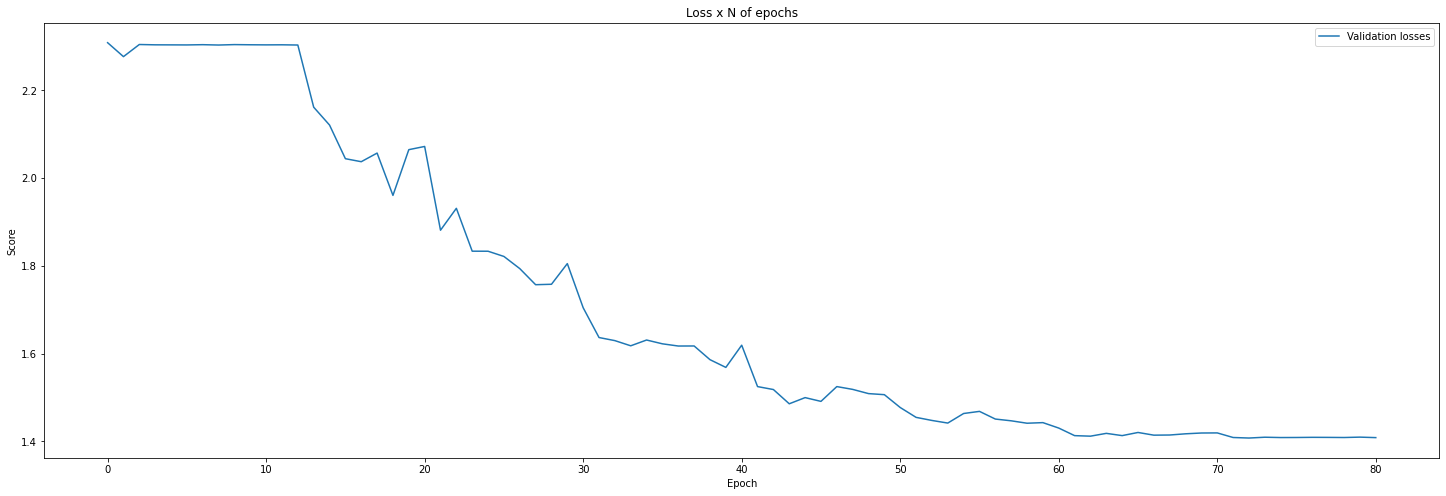

In [ ]:
plot_losses(history_4)

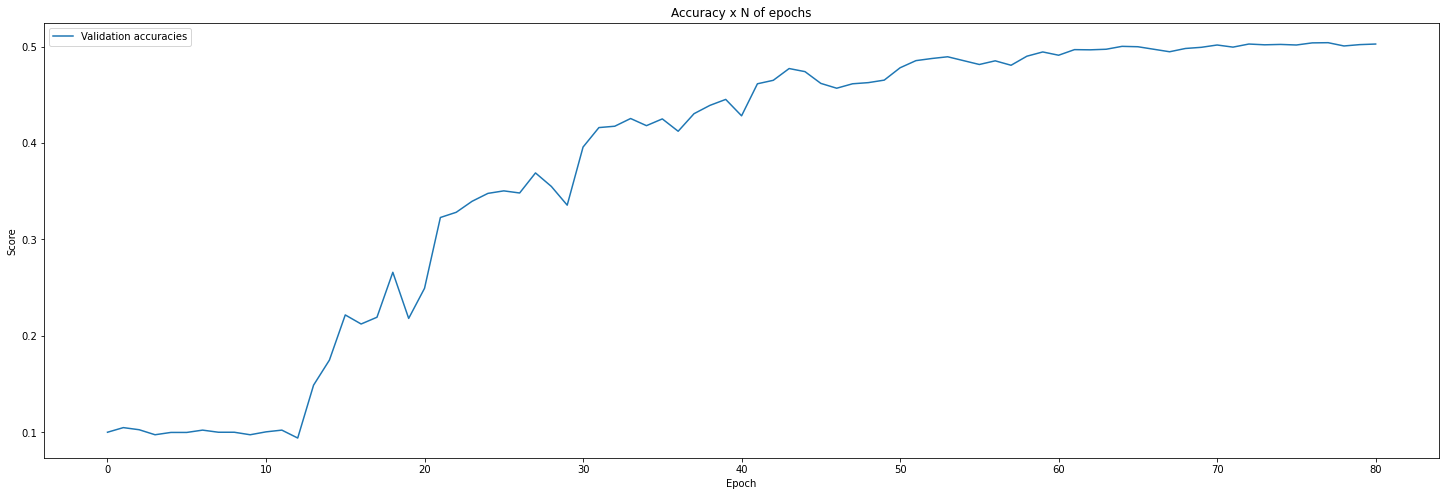

In [ ]:
plot_accuracies(history_4)

#Model 5

In [ ]:
___ = []
x_ = 3
while x_ < input_size:
  ___.append(x_)
  x_ = x_ * 3
___

[3, 9, 27, 81, 243, 729, 2187]

In [ ]:
class cifar10model_5(ImgClassificationBase):
  '''
  7 hidden layers, all linear, 2 in the power of 2
  input(3072)--2048--1024--512--256--128--64--32--16--output(10)
  Activarion: ReLU
  '''
  def __init__(self, input_size, n_classes):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 2048)
    self.linear2 = nn.Linear(2048, 1024)
    self.linear3 = nn.Linear(1024, 512)
    self.linear4 = nn.Linear(512, 256)
    self.linear5 = nn.Linear(256, 128)
    self.linear6 = nn.Linear(128, 64)
    self.linear7 = nn.Linear(64, 32)
    self.linear8 = nn.Linear(32, 16)
    self.linear9 = nn.Linear(16, n_classes)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    out = F.relu(out)
    out = self.linear5(out)
    out = F.relu(out)
    out = self.linear6(out)
    out = F.relu(out)
    out = self.linear7(out)
    out = F.relu(out)
    out = self.linear8(out)
    out = F.relu(out)
    out = self.linear9(out)
    return out

In [ ]:
model5 = cifar10model_5(input_size, n_classes)

In [ ]:
model5 = to_device(model5, device)

In [ ]:
history_5 = [evaluate(model5, validation_loader)]
history_5

[{'epoch_acc': 0.10240001231431961, 'epoch_loss': 2.3140406608581543}]

In [ ]:
history_5 += fit(10, model5, train_loader, validation_loader, 0.45)

Epoch: [0], Validation loss: [2.3038], Validation accuracy: [0.1028]
Epoch: [1], Validation loss: [2.3041], Validation accuracy: [0.1008]
Epoch: [2], Validation loss: [2.1558], Validation accuracy: [0.1562]
Epoch: [3], Validation loss: [2.0601], Validation accuracy: [0.1912]
Epoch: [4], Validation loss: [2.0138], Validation accuracy: [0.2052]
Epoch: [5], Validation loss: [2.0626], Validation accuracy: [0.2016]
Epoch: [6], Validation loss: [1.9066], Validation accuracy: [0.254]
Epoch: [7], Validation loss: [1.9249], Validation accuracy: [0.2778]
Epoch: [8], Validation loss: [1.8332], Validation accuracy: [0.3096]
Epoch: [9], Validation loss: [1.9406], Validation accuracy: [0.2788]


In [ ]:
history_5 += fit(10, model5, train_loader, validation_loader, 0.4)

Epoch: [0], Validation loss: [1.7529], Validation accuracy: [0.3612]
Epoch: [1], Validation loss: [1.8463], Validation accuracy: [0.3476]
Epoch: [2], Validation loss: [1.7906], Validation accuracy: [0.3666]
Epoch: [3], Validation loss: [1.8087], Validation accuracy: [0.354]
Epoch: [4], Validation loss: [1.6743], Validation accuracy: [0.3926]
Epoch: [5], Validation loss: [1.6073], Validation accuracy: [0.4212]
Epoch: [6], Validation loss: [1.7235], Validation accuracy: [0.3906]
Epoch: [7], Validation loss: [1.7509], Validation accuracy: [0.3942]
Epoch: [8], Validation loss: [1.627], Validation accuracy: [0.4264]
Epoch: [9], Validation loss: [1.613], Validation accuracy: [0.4368]


In [ ]:
history_5 += fit(10, model5, train_loader, validation_loader, 0.3)

Epoch: [0], Validation loss: [1.5405], Validation accuracy: [0.4564]
Epoch: [1], Validation loss: [1.4768], Validation accuracy: [0.4734]
Epoch: [2], Validation loss: [1.5482], Validation accuracy: [0.4526]
Epoch: [3], Validation loss: [1.5087], Validation accuracy: [0.4724]
Epoch: [4], Validation loss: [1.5078], Validation accuracy: [0.4736]
Epoch: [5], Validation loss: [1.5572], Validation accuracy: [0.4554]
Epoch: [6], Validation loss: [1.4945], Validation accuracy: [0.4906]
Epoch: [7], Validation loss: [1.5641], Validation accuracy: [0.4562]
Epoch: [8], Validation loss: [1.4931], Validation accuracy: [0.4924]
Epoch: [9], Validation loss: [1.467], Validation accuracy: [0.4878]


In [ ]:
history_5 += fit(10, model5, train_loader, validation_loader, 0.2)

Epoch: [0], Validation loss: [1.454], Validation accuracy: [0.5106]
Epoch: [1], Validation loss: [1.5593], Validation accuracy: [0.476]
Epoch: [2], Validation loss: [1.5384], Validation accuracy: [0.4976]
Epoch: [3], Validation loss: [1.5155], Validation accuracy: [0.495]
Epoch: [4], Validation loss: [1.5476], Validation accuracy: [0.5028]
Epoch: [5], Validation loss: [1.5028], Validation accuracy: [0.5074]
Epoch: [6], Validation loss: [1.5885], Validation accuracy: [0.4936]
Epoch: [7], Validation loss: [1.6095], Validation accuracy: [0.4812]
Epoch: [8], Validation loss: [1.6913], Validation accuracy: [0.4778]
Epoch: [9], Validation loss: [1.65], Validation accuracy: [0.5024]


In [ ]:
history_5 += fit(10, model5, train_loader, validation_loader, 0.1)

Epoch: [0], Validation loss: [1.7096], Validation accuracy: [0.5162]
Epoch: [1], Validation loss: [1.781], Validation accuracy: [0.5148]
Epoch: [2], Validation loss: [1.8898], Validation accuracy: [0.5142]
Epoch: [3], Validation loss: [1.8624], Validation accuracy: [0.516]
Epoch: [4], Validation loss: [1.9794], Validation accuracy: [0.5062]
Epoch: [5], Validation loss: [1.9571], Validation accuracy: [0.508]
Epoch: [6], Validation loss: [2.0424], Validation accuracy: [0.5064]
Epoch: [7], Validation loss: [2.0539], Validation accuracy: [0.503]
Epoch: [8], Validation loss: [2.0828], Validation accuracy: [0.5142]
Epoch: [9], Validation loss: [2.219], Validation accuracy: [0.503]


In [ ]:
history_5 += fit(10, model5, train_loader, validation_loader, 0.05)

Epoch: [0], Validation loss: [2.4491], Validation accuracy: [0.521]
Epoch: [1], Validation loss: [2.6873], Validation accuracy: [0.516]
Epoch: [2], Validation loss: [2.8572], Validation accuracy: [0.514]
Epoch: [3], Validation loss: [3.0551], Validation accuracy: [0.5088]
Epoch: [4], Validation loss: [3.0671], Validation accuracy: [0.5058]
Epoch: [5], Validation loss: [3.1142], Validation accuracy: [0.5164]
Epoch: [6], Validation loss: [3.114], Validation accuracy: [0.5108]
Epoch: [7], Validation loss: [3.1697], Validation accuracy: [0.5118]
Epoch: [8], Validation loss: [3.1541], Validation accuracy: [0.512]
Epoch: [9], Validation loss: [3.2202], Validation accuracy: [0.5024]


In [ ]:
history_5 += fit(10, model5, train_loader, validation_loader, 0.01)

Epoch: [0], Validation loss: [3.2434], Validation accuracy: [0.5184]
Epoch: [1], Validation loss: [3.3311], Validation accuracy: [0.5184]
Epoch: [2], Validation loss: [3.4093], Validation accuracy: [0.52]
Epoch: [3], Validation loss: [3.4755], Validation accuracy: [0.5206]
Epoch: [4], Validation loss: [3.5399], Validation accuracy: [0.5204]
Epoch: [5], Validation loss: [3.5992], Validation accuracy: [0.5162]
Epoch: [6], Validation loss: [3.6497], Validation accuracy: [0.5168]
Epoch: [7], Validation loss: [3.6997], Validation accuracy: [0.5172]
Epoch: [8], Validation loss: [3.7499], Validation accuracy: [0.518]
Epoch: [9], Validation loss: [3.7896], Validation accuracy: [0.5168]


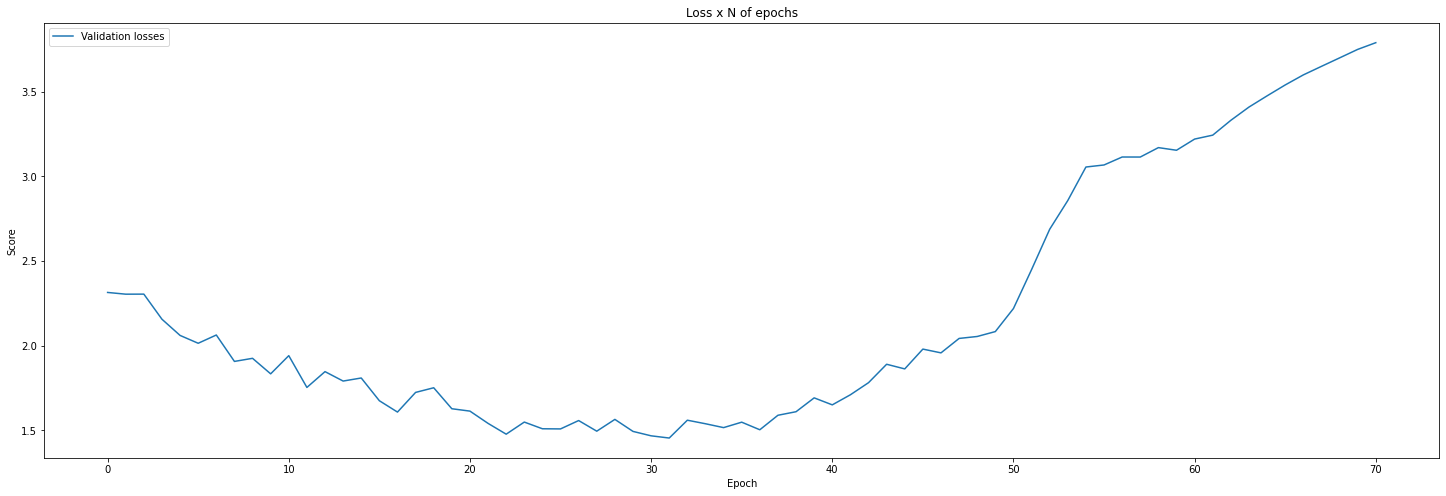

In [ ]:
plot_losses(history_5)

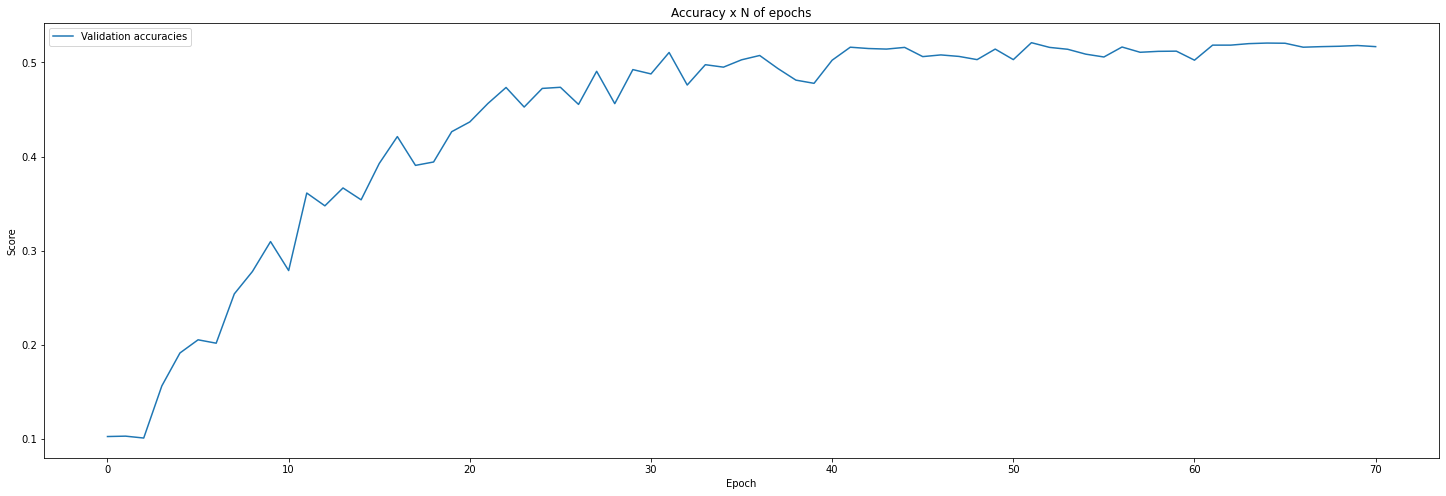

In [ ]:
plot_accuracies(history_5)

##Model 6

In [ ]:
# [3, 9, 27, 81, 243, 729, 2187]
class cifar10model_6(ImgClassificationBase):
  '''
  4 hidden layers, all linear, squares of 3
  input(3072)--2187--729--243--81--27--output(10)
  Activation: ReLU
  '''
  def __init__(self, input_size, n_classes):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 2187)
    self.linear2 = nn.Linear(2187, 729)
    self.linear3 = nn.Linear(729, 243)
    self.linear4 = nn.Linear(243, 81)
    self.linear5 = nn.Linear(81, 27)
    self.linear6 = nn.Linear(27, n_classes)

  def forward(self, xb):
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.relu(out)
    out = self.linear4(out)
    out = F.relu(out)
    out = self.linear5(out)
    out = F.relu(out)
    out = self.linear6(out)
    return out

In [ ]:
model6 = cifar10model_6(input_size, n_classes)

In [ ]:
model6 = to_device(model6, device)

In [ ]:
history_6 = [evaluate(model6, validation_loader)]
history_6

[{'epoch_acc': 0.10240001231431961, 'epoch_loss': 2.307549476623535}]

In [ ]:
history_6 += fit(10, model6, train_loader, validation_loader, 0.45)

Epoch: [0], Validation loss: [2.3692], Validation accuracy: [0.1052]
Epoch: [1], Validation loss: [1.9695], Validation accuracy: [0.2656]
Epoch: [2], Validation loss: [2.0058], Validation accuracy: [0.272]
Epoch: [3], Validation loss: [1.8165], Validation accuracy: [0.3442]
Epoch: [4], Validation loss: [1.7411], Validation accuracy: [0.37]
Epoch: [5], Validation loss: [1.8347], Validation accuracy: [0.349]
Epoch: [6], Validation loss: [1.6715], Validation accuracy: [0.3996]
Epoch: [7], Validation loss: [1.6446], Validation accuracy: [0.4162]
Epoch: [8], Validation loss: [1.6475], Validation accuracy: [0.4154]
Epoch: [9], Validation loss: [1.5924], Validation accuracy: [0.4314]


In [ ]:
history_6 += fit(10, model6, train_loader, validation_loader, 0.4)

Epoch: [0], Validation loss: [1.5787], Validation accuracy: [0.4432]
Epoch: [1], Validation loss: [1.5577], Validation accuracy: [0.4422]
Epoch: [2], Validation loss: [1.5279], Validation accuracy: [0.4636]
Epoch: [3], Validation loss: [1.5568], Validation accuracy: [0.4442]
Epoch: [4], Validation loss: [1.523], Validation accuracy: [0.4542]
Epoch: [5], Validation loss: [1.5284], Validation accuracy: [0.4666]
Epoch: [6], Validation loss: [1.513], Validation accuracy: [0.4682]
Epoch: [7], Validation loss: [1.4989], Validation accuracy: [0.4706]
Epoch: [8], Validation loss: [1.4531], Validation accuracy: [0.4912]
Epoch: [9], Validation loss: [1.5129], Validation accuracy: [0.4738]


In [ ]:
history_6 += fit(10, model6, train_loader, validation_loader, 0.3)

Epoch: [0], Validation loss: [1.4484], Validation accuracy: [0.4976]
Epoch: [1], Validation loss: [1.442], Validation accuracy: [0.5048]
Epoch: [2], Validation loss: [1.4539], Validation accuracy: [0.4998]
Epoch: [3], Validation loss: [1.4563], Validation accuracy: [0.5024]
Epoch: [4], Validation loss: [1.5181], Validation accuracy: [0.4868]
Epoch: [5], Validation loss: [1.4982], Validation accuracy: [0.4966]
Epoch: [6], Validation loss: [1.5444], Validation accuracy: [0.4904]
Epoch: [7], Validation loss: [1.5199], Validation accuracy: [0.4922]
Epoch: [8], Validation loss: [1.4949], Validation accuracy: [0.506]
Epoch: [9], Validation loss: [1.565], Validation accuracy: [0.4986]


In [ ]:
history_6 += fit(10, model6, train_loader, validation_loader, 0.2)

Epoch: [0], Validation loss: [1.549], Validation accuracy: [0.5258]
Epoch: [1], Validation loss: [1.678], Validation accuracy: [0.5082]
Epoch: [2], Validation loss: [1.6274], Validation accuracy: [0.5188]
Epoch: [3], Validation loss: [1.6575], Validation accuracy: [0.5158]
Epoch: [4], Validation loss: [1.7546], Validation accuracy: [0.4916]
Epoch: [5], Validation loss: [1.7886], Validation accuracy: [0.4928]
Epoch: [6], Validation loss: [1.8061], Validation accuracy: [0.5064]
Epoch: [7], Validation loss: [1.8309], Validation accuracy: [0.4858]
Epoch: [8], Validation loss: [1.8372], Validation accuracy: [0.5092]
Epoch: [9], Validation loss: [1.8789], Validation accuracy: [0.5098]


In [ ]:
history_6 += fit(10, model6, train_loader, validation_loader, 0.1)

Epoch: [0], Validation loss: [2.1299], Validation accuracy: [0.5256]
Epoch: [1], Validation loss: [2.3104], Validation accuracy: [0.513]
Epoch: [2], Validation loss: [2.5066], Validation accuracy: [0.513]
Epoch: [3], Validation loss: [2.6182], Validation accuracy: [0.5086]
Epoch: [4], Validation loss: [2.7602], Validation accuracy: [0.5056]
Epoch: [5], Validation loss: [2.7718], Validation accuracy: [0.5078]
Epoch: [6], Validation loss: [2.9124], Validation accuracy: [0.508]
Epoch: [7], Validation loss: [2.8781], Validation accuracy: [0.501]
Epoch: [8], Validation loss: [3.0613], Validation accuracy: [0.5008]
Epoch: [9], Validation loss: [2.9932], Validation accuracy: [0.5096]


In [ ]:
history_6 += fit(10, model6, train_loader, validation_loader, 0.05)

Epoch: [0], Validation loss: [3.2106], Validation accuracy: [0.5134]
Epoch: [1], Validation loss: [3.5095], Validation accuracy: [0.5172]
Epoch: [2], Validation loss: [3.7035], Validation accuracy: [0.5122]
Epoch: [3], Validation loss: [3.8792], Validation accuracy: [0.51]
Epoch: [4], Validation loss: [4.0648], Validation accuracy: [0.5158]
Epoch: [5], Validation loss: [4.1829], Validation accuracy: [0.5154]
Epoch: [6], Validation loss: [4.3368], Validation accuracy: [0.5152]
Epoch: [7], Validation loss: [4.4649], Validation accuracy: [0.5154]
Epoch: [8], Validation loss: [4.6052], Validation accuracy: [0.5142]
Epoch: [9], Validation loss: [4.7174], Validation accuracy: [0.5146]


In [ ]:
history_6 += fit(10, model6, train_loader, validation_loader, 0.01)

Epoch: [0], Validation loss: [4.7356], Validation accuracy: [0.5146]
Epoch: [1], Validation loss: [4.764], Validation accuracy: [0.5152]
Epoch: [2], Validation loss: [4.7885], Validation accuracy: [0.514]
Epoch: [3], Validation loss: [4.8098], Validation accuracy: [0.5136]
Epoch: [4], Validation loss: [4.8316], Validation accuracy: [0.5158]
Epoch: [5], Validation loss: [4.8479], Validation accuracy: [0.515]
Epoch: [6], Validation loss: [4.8715], Validation accuracy: [0.5156]
Epoch: [7], Validation loss: [4.8886], Validation accuracy: [0.5156]
Epoch: [8], Validation loss: [4.9104], Validation accuracy: [0.5146]
Epoch: [9], Validation loss: [4.9266], Validation accuracy: [0.5148]


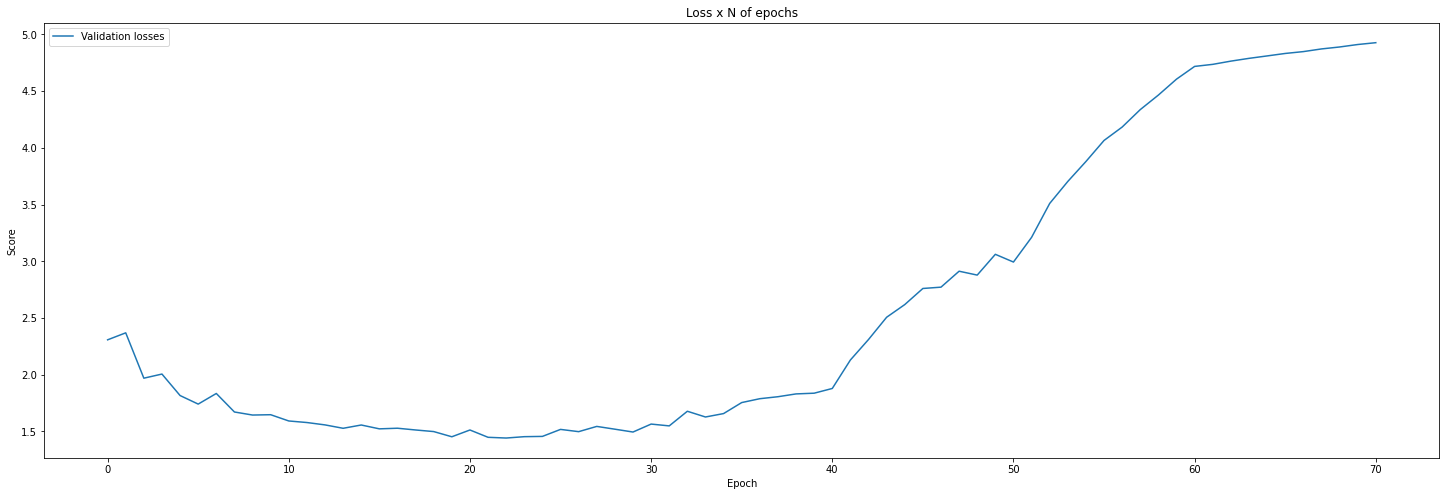

In [ ]:
plot_losses(history_6)

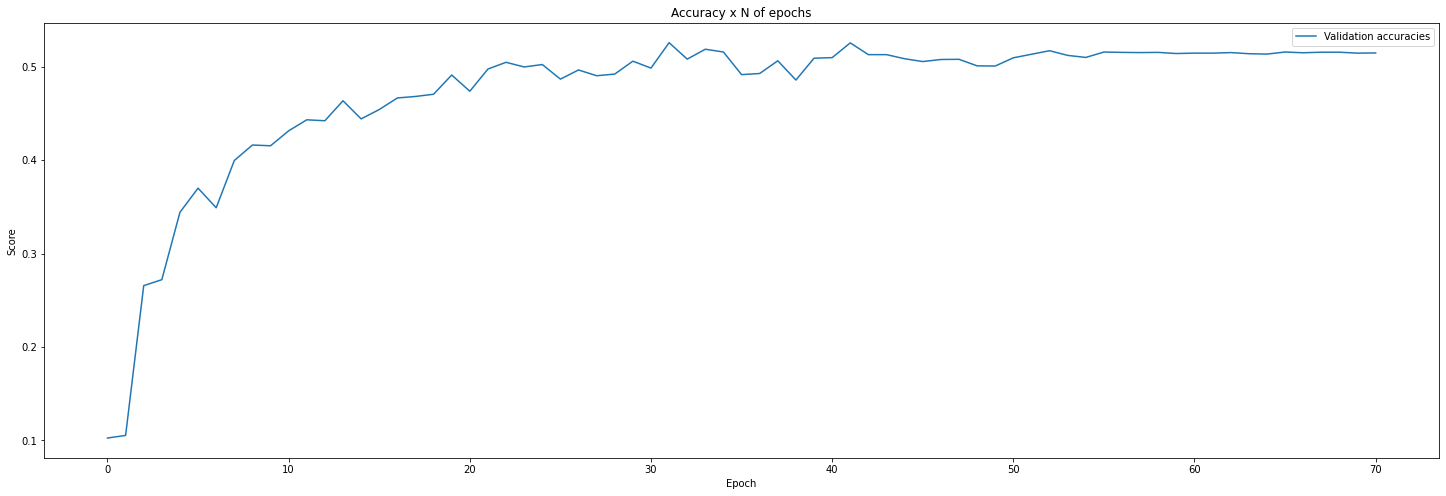

In [ ]:
plot_accuracies(history_6)

#Evaluation

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [ ]:
test_acc_1 = evaluate(model_1, test_loader)
test_acc_2 = evaluate(model2, test_loader)
test_acc_3 = evaluate(model3, test_loader)
test_acc_4 = evaluate(model4, test_loader)
test_acc_5 = evaluate(model5, test_loader)
test_acc_6 = evaluate(model6, test_loader)

In [ ]:
print(f'Model 1 test evaluation metrics: {test_acc_1}')
print(f'Model 2 test evaluation metrics: {test_acc_2}')
print(f'Model 3 test evaluation metrics: {test_acc_3}')
print(f'Model 4 test evaluation metrics: {test_acc_4}')
print(f'Model 5 test evaluation metrics: {test_acc_5}')
print(f'Model 6 test evaluation metrics: {test_acc_6}')

Model 1 test evaluation metrics: {'epoch_loss': 1.725175142288208, 'epoch_acc': 0.3636999726295471}
Model 2 test evaluation metrics: {'epoch_loss': 4.3482160568237305, 'epoch_acc': 0.525700032711029}
Model 3 test evaluation metrics: {'epoch_loss': 2.3027184009552, 'epoch_acc': 0.10000000894069672}
Model 4 test evaluation metrics: {'epoch_loss': 1.4091583490371704, 'epoch_acc': 0.5106000304222107}
Model 5 test evaluation metrics: {'epoch_loss': 3.845414638519287, 'epoch_acc': 0.5221999883651733}
Model 6 test evaluation metrics: {'epoch_loss': 4.8985595703125, 'epoch_acc': 0.5240999460220337}


In [ ]:
model_evaluations = [test_acc_1, test_acc_2, test_acc_3, test_acc_4, test_acc_5, test_acc_6]

In [ ]:
model_losses = [x['epoch_loss'] for x in model_evaluations]
model_accuracies = [x['epoch_acc'] for x in model_evaluations]

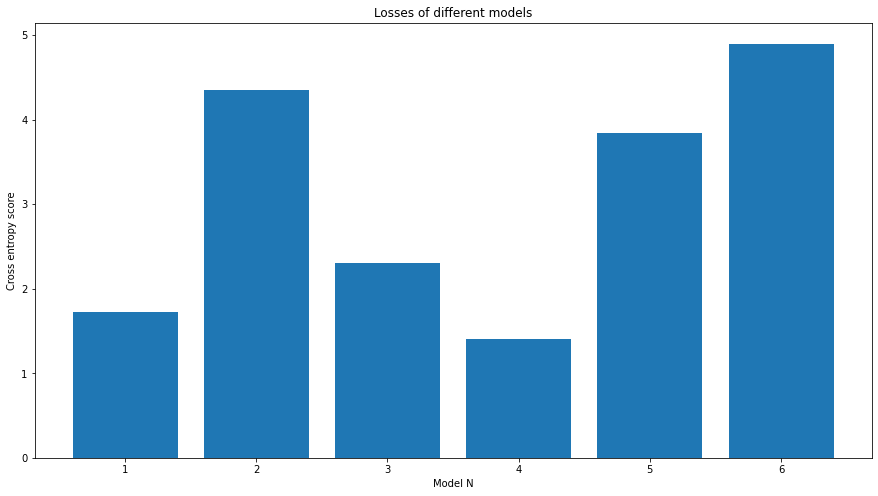

In [ ]:
plt.figure(figsize=(15, 8))
plt.bar([1, 2, 3, 4, 5, 6], model_losses)
plt.title('Losses of different models')
plt.xlabel('Model N')
plt.ylabel('Cross entropy score');

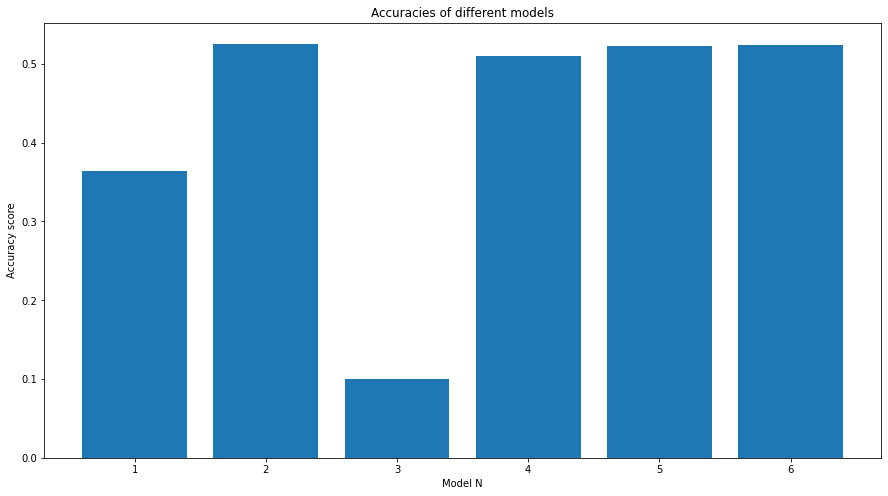

In [ ]:
plt.figure(figsize=(15, 8))
plt.bar([1, 2, 3, 4, 5, 6], model_accuracies)
plt.title('Accuracies of different models')
plt.xlabel('Model N')
plt.ylabel('Accuracy score');

In [ ]:
print(f'The model with the least loss is model N {model_losses.index(min(model_losses)) + 1} with the accuracy of {max(model_losses)}')
print(f'The most accurate model is model N {model_accuracies.index(max(model_accuracies)) + 1} with the accuracy of {max(model_accuracies) * 100} %')

The model with the least loss is model N 4 with the accuracy of 4.8985595703125
The most accurate model is model N 2 with the accuracy of 52.570003271102905 %


Label: 3 , Predicted: 3
Label: cat , Predicted: cat


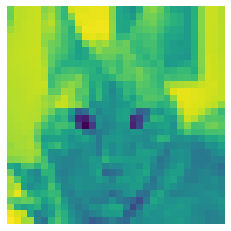

In [ ]:
img, label = dataset_test[1123]
plt.imshow(img[0])
plt.axis('off')
print('Label:', label, ', Predicted:', predict_image(img, model2))
print('Label:', classes[label], ', Predicted:', classes[predict_image(img, model2)])

In [ ]:
torch.save(model_1.state_dict(), 'model1-cifar10.sth')
torch.save(model2.state_dict(), 'model2-cifar10.sth')
torch.save(model3.state_dict(), 'model3-cifar10.sth')
torch.save(model4.state_dict(), 'model4-cifar10.sth')
torch.save(model5.state_dict(), 'model5-cifar10.sth')
torch.save(model6.state_dict(), 'model6-cifar10.sth')

In [ ]:
# create folder
!mkdir '/content/drive/MyDrive/kaggle competitions/cifar10'
%cd '/content/drive/MyDrive/kaggle competitions/cifar10'

/content/drive/MyDrive/kaggle competitions/cifar10


In [ ]:
# copy it there
!cp /content/model1-cifar10.sth '/content/drive/MyDrive/kaggle competitions/cifar10'
!cp /content/model2-cifar10.sth '/content/drive/MyDrive/kaggle competitions/cifar10'
!cp /content/model3-cifar10.sth '/content/drive/MyDrive/kaggle competitions/cifar10'
!cp /content/model4-cifar10.sth '/content/drive/MyDrive/kaggle competitions/cifar10'
!cp /content/model5-cifar10.sth '/content/drive/MyDrive/kaggle competitions/cifar10'
!cp /content/model6-cifar10.sth '/content/drive/MyDrive/kaggle competitions/cifar10'
#!cp /content/data/ 'content/drive/MyDrive/kaggle competitions/cifar10'

cp: -r not specified; omitting directory '/content/data/'
